# Process-Oriented Simulation of M/G/1 Queues

The event-driven approach is more than sufficient to handle the single-server queue with the FIFO queuing discipline. However, the situation may get a bit complicated using the event-driven approach, especially when we deal with multiple servers with multiple queues and with more complicated queuing disciplines (such as priority-based scheduling with preemption). 

One favorable feature of simulus that distinguishes it from most other simulators is its natural support for process-oriented simulation. Simulus provides high-level modeling abstractions (such as traps, semaphores, resources, stores, and mailboxes) for users to create more intuitive and expressive simulation models using the process-oriented approach. We start here to discuss using process-oriented simulation for the single-server queue with exponentially distributed inter-arrival time and a truncated normal distribution for the service time. Later we will expand the proccess-oriented model for more complicated queuing scenarios.

Rather than directly scheduling events (one still can if needs to), we create processes and have the processes to run their own course. Each process is a single thread of control. A process can be suspended, sleeping for time or waiting for resources. A process can resume execution, after sleep or when the wait conditions have been satisfied.

Before we start this section, let's first run the following so that we can set up the environment and import the necessary packages.

In [1]:
import random
import numpy as np
import scipy.stats as stats
import simulus
from qmodels.rng import expon, truncnorm

import matplotlib.pyplot as plt
%matplotlib inline

# for animation inside the notebook
import ipywidgets as widgets
from ipywidgets import interact

# set up logging for this module
import logging
log = logging.getLogger(__name__)
log.addHandler(logging.NullHandler())

## Using Processes

For the single-server queue, we use a process to generate the customers. A process starts from a normal function, in this case, `gen_arrivals()`. Within the function, the process enters a for-loop, in which the process sleeps for some time (which is a random value returned from the `inter_arrival_time` generator function), and then creates another process that starts from a function called 'customer'. As its name suggests, the process represents a customer who arrives at the queue. 

In [2]:
def gen_arrivals():
    while True:
        sim.sleep(next(inter_arrival_time))
        sim.process(customer)

The customer process waits for a server to be available. A server in this case is implemented as a resource. A process trying to acquire a resource may be suspended if the resource is unavailable (i.e., if it has been already acquired by another customer). In that case, the process will be put in a queue (with unlimited space) maintained by the resource. 

Once the server becomes available, one of the waiting processes will be selected. By default, the resource is FIFO: it selects the waiting process who has entered the queue first. When the selected process acquires the server, it sleeps for some time representing the customer being served. The sleep time is a random value returned from the `service_time` generator function. After the sleep, the process releases the server so that if other customer processes are waiting for the server, the server will select the next customer in queue.

In [3]:
def customer():
    log.info('%g: customer arrives (num_in_system=%d->%d)' %
             (sim.now, server.num_in_system(), server.num_in_system()+1))
    server.acquire()
    sim.sleep(next(service_time))
    log.info('%g: customer departs (num_in_system=%d->%d)' %
             (sim.now, server.num_in_system(), server.num_in_system()-1))
    server.release()

Now we are ready to simulate the queue. Like before, we instantiate a simulator and then create the two generators for the inter-arrival time and for the service time. For a start, let's use exponential distribution first. After that, we create the server as a resource and then starts the 'gen_arrivals' process. Finally we run the simulation for 10 simulated seconds. The results should be similar to those from the event-driven approach.

In [4]:
random.seed(13579) # global random seed

# set logging to info level (will print all info messages)
logging.basicConfig()
logging.getLogger(__name__).setLevel(logging.INFO)

sim = simulus.simulator('mm1')
inter_arrival_time = expon(1.2, sim.rng().randrange(2**32))
service_time = expon(0.8, sim.rng().randrange(2**32))
server = sim.resource()
sim.process(gen_arrivals)
sim.run(10)

INFO:__main__:0.117886: customer arrives (num_in_system=0->1)
INFO:__main__:0.440574: customer departs (num_in_system=1->0)
INFO:__main__:0.442274: customer arrives (num_in_system=0->1)
INFO:__main__:1.34061: customer departs (num_in_system=1->0)
INFO:__main__:1.4955: customer arrives (num_in_system=0->1)
INFO:__main__:1.59616: customer departs (num_in_system=1->0)
INFO:__main__:1.78134: customer arrives (num_in_system=0->1)
INFO:__main__:2.09363: customer arrives (num_in_system=1->2)
INFO:__main__:2.50151: customer departs (num_in_system=2->1)
INFO:__main__:2.63192: customer departs (num_in_system=1->0)
INFO:__main__:6.51199: customer arrives (num_in_system=0->1)
INFO:__main__:7.05751: customer arrives (num_in_system=1->2)
INFO:__main__:7.32092: customer departs (num_in_system=2->1)
INFO:__main__:8.02589: customer arrives (num_in_system=1->2)
INFO:__main__:8.05119: customer arrives (num_in_system=2->3)
INFO:__main__:8.95281: customer arrives (num_in_system=3->4)
INFO:__main__:9.55017:

It's easy to change the service time distribution from exponential to a truncated normal distribution, which specifies a particular range between a and b. We use another generator function for this, called 'truncnorm()', which is also provided in the qmodels.rng module. 

## Data Collection and Simulation On-the-Fly

We are going to run the simulation and show the effect of the service time distribution on the customer's wait time *on the fly*. To do this, we are wrapping around each simulation run using a function called `simrun()`. In this case, we can simply call this function to have one run of the simulation and return the results. Since in our example both `gen_arrivals()` and `customer()` use module global variables: 'sim', 'inter_arrival_time', 'service_time', and 'server'. We need to make them global from the `simrun()` function. In the example code, we create an `mg1` class to hold these variables.

To gather the statistics, we use DataCollector provided by simulus. When creating the DataCollector instance, we specify the kind of data to be gathered at the resource. In this example, we would like to keep all the data series for `system_times`, which is just another name for the wait time of all the customers using the resource. When we create the resource, we attach the DataCollector instance. After the simulation run, we retrieve the collected data from the DataCollector instance and return them from the function.

In [5]:
# turn off  info level printing
logging.getLogger(__name__).setLevel(logging.WARNING)

def simrun(a, b):
    global sim, inter_arrival_time, service_time, server
    sim = simulus.simulator('mg1')
    inter_arrival_time = expon(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm(a, b, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries(all)')
    server = sim.resource(collect=dc)
    sim.process(gen_arrivals)
    sim.run(1000)
    return dc.system_times.data()

Now we are all set for interactive plotting. We fix 'a' and use a slider to choose 'b'. The `plot_hist()` function calls `simrun()` to get the wait time of all customers in a list and we plot the histogram accordingly.

In [6]:
def plot_hist(a, b):
    waits = simrun(a, b)
    plt.hist(waits, alpha=0.5, bins='auto', density=True)
    plt.xlim(0, 8)
    plt.show()
interact(plot_hist, a=widgets.fixed(0), b=(0.1, 2.0, 0.1))
None

interactive(children=(FloatSlider(value=1.0, description='b', max=2.0, min=0.1), Output()), _dom_classes=('wid…

## Multiple Simulation Runs

The wait time shown in the histogram is from one run of the simulation. To be statistically meaningful, we need to run many trials of each simulation setting and show the results with confidence intervals.

In the following example, we revise the `simrun()` function to just collect the summary statistics for wait time and return the mean value (which would consume far less time and memory). This is achieved by configuring the DataCollector with the argument 'system_times' set to be 'dataseries' rather than 'dataseries(all)'.

We run the simulation for 25 times at each parameter setting. It is important to note that there's a subtle difference from the previous when we create the simulator for each simulation run. Now the simulator is nameless! This is important, because otherwise the simulator will generate the same random sequence regardless of how many times we run the simulation. Without a name, the simulator will be created with a randomly generated name (using the default random number generator in Python's `random` module). Recall that the simulator's attached random number generator is seeded from the namespace (which we do not change since we use the same global random seed) and the simulator's name. In this case, the simulator would create a different random sequence, which is exactly what we'd need. 

In [7]:
def simrun(a, b):
    global sim, inter_arrival_time, service_time, server
    sim = simulus.simulator()
    inter_arrival_time = expon(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm(a, b, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries')
    server = sim.resource(collect=dc)
    sim.process(gen_arrivals)
    sim.run(100)
    return dc.system_times.mean()

The following code will run pretty slow. Be prepared! We are conducting 30*25=750 simulation runs before we can get the plot. 

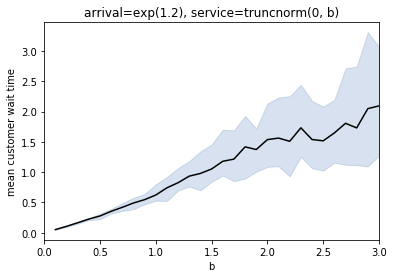

In [8]:
x = np.linspace(0.1, 3.0, 30)
y = []
e1 = []
e2 = []
for b in x:
    z = []
    for _ in range(25):
        z.append(simrun(0, b))
    z = np.array(z)
    y.append(z.mean())
    e1.append(np.percentile(z, 5))
    e2.append(np.percentile(z, 95))

plt.plot(x, y, 'k-')
plt.xlim(0, 3.0)
plt.title('arrival=exp(1.2), service=truncnorm(0, b)')
plt.ylabel('mean customer wait time')
plt.xlabel('b')
plt.fill_between(x, e1, e2, color='#386cb0', alpha=0.2)
plt.show()

The above plot shows that the mean wait time generally increases as we increase 'b', which increases both the mean and the standard deviation of the service time. The confidence interval also seems to be getting larger as we increase 'b'. 

As 'b' increases, the service rate decreases and the difference between the arrival rate and service rate decreases as a result. It takes longer for the simulation to reach steady state. We fixed each simulation run to last for 1000 simulated seconds, which may not be sufficient for a larger 'b'.